# Forecasting electricity load using a LSTM neural network

This LSTM network was thrown together to get a quick comparison of LSTM and GAM/Fourier (Fbprophet).

The LSTM network is layered into two stacks, one with 32 and one with 16 neurons. The last layer is a fully connected layer with 36 output neurons with ReLU activation, one for each of the 36 hours predicted.

I could not figure out how to include forecasted temperature in the model. This is a big limitation of the model and limits the performance. Information about holidays are also missing, although less sever.

Even without updated temperature data and holidays, it performs better than the GAM/Fbprophet model. The GAM model has a mean average error (MAE) of **551.45 MW** over a 0–36 hours forecast. This LSTM model has MAE of **417 MW**.

It is not a perfect comparison. The GAM-model only changes trend changepoints every other month, while the LSTM model is optimalized for short term predictions, and can better use the latest load as a baseline. It therefore should do better on short term predictions. Intuitivly I guess the LSTM model has stronger problems if was used on far-ahead predictions, because of looser model constraints and limited data.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

tf.__version__

# Matplotlib style sheet
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-pastel')
plt.style.use('jont')

In [2]:
tf.random.set_seed(13)

In [3]:
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
months = ("January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")

In [4]:
# Load dataset

filename = "NO_load_actual_entsoe_power_statistics.csv"
df = pd.read_csv(filename)
df.index = pd.to_datetime(df.datetime)
df = df.drop(columns=["datetime"])

display(df.head())

print(len(df))

,load_mw,temp_c
datetime,,
2010-01-01 00:00:00,17898.0,-9.958
2010-01-01 01:00:00,17671.0,-9.953
2010-01-01 02:00:00,17500.0,-10.098
2010-01-01 03:00:00,17362.0,-10.344
2010-01-01 04:00:00,17470.0,-10.586


61360


In [5]:
load_mean = df.load_mw.mean()
load_std = df.load_mw.std()
print("Mean: %.2f, St.d: %.2f" % (load_mean, load_std))

def denormalize(normalized_load):
    return load_std * normalized_load + load_mean

dataset_normalized = (df-df.mean())/df.std()
dataset_normalized.head()

Mean: 14625.57, St.d: 3277.15


,load_mw,temp_c
datetime,,
2010-01-01 00:00:00,0.998559,-1.825203
2010-01-01 01:00:00,0.929292,-1.824565
2010-01-01 02:00:00,0.877112,-1.843068
2010-01-01 03:00:00,0.835002,-1.874458
2010-01-01 04:00:00,0.867958,-1.905338


In [6]:
d = dataset_normalized.copy()
d = d.join(pd.Series(df.index.dayofyear.values, index=df.index, name="dayofyear")/365)
d = d.join(pd.Series(df.index.hour.values, index=df.index, name="hour"))
d = d.join(pd.DataFrame(pd.get_dummies(df.index.dayofweek).values, index=df.index, columns=weekDays))
dataset = d.copy()
dataset.head()

,load_mw,temp_c,dayofyear,hour,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
datetime,,,,,,,,,,,
2010-01-01 00:00:00,0.998559,-1.825203,0.00274,0,0,0,0,0,1,0,0
2010-01-01 01:00:00,0.929292,-1.824565,0.00274,1,0,0,0,0,1,0,0
2010-01-01 02:00:00,0.877112,-1.843068,0.00274,2,0,0,0,0,1,0,0
2010-01-01 03:00:00,0.835002,-1.874458,0.00274,3,0,0,0,0,1,0,0
2010-01-01 04:00:00,0.867958,-1.905338,0.00274,4,0,0,0,0,1,0,0


In [7]:
target_column_index = 0
target = dataset.values[:,0]

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    number_of_values = (end_index - start_index)
    number_of_features = len(dataset[0])

    x = np.zeros(shape=[number_of_values, history_size, number_of_features])
    y = np.zeros(shape=[number_of_values, target_size])

    for i in range(number_of_values):
        i_dataset = i + start_index
        
        slice_dataset = slice(i_dataset-history_size, i_dataset, step)
        x[i] = dataset[slice_dataset]

        slice_target = slice(i_dataset, i_dataset+target_size)
        y[i] = target[slice_target]

    return x, y

In [9]:
past_history = 7*24  # 7 days
STEP = 1             # Do not jump over any
target_size = 36     # hours



TRAIN_SPLIT = 5*365*24

x_train, y_train = multivariate_data(
    dataset.values, 
    target=target, 
    start_index=0,
    end_index=TRAIN_SPLIT, 
    history_size=past_history,
    target_size=target_size, 
    step=STEP
)

x_val, y_val = multivariate_data(
    dataset.values, 
    target=target, 
    start_index=TRAIN_SPLIT,
    end_index=None, 
    history_size=past_history,
    target_size=target_size, 
    step=STEP
)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(43632, 168, 11)
(43632, 36)
(17454, 168, 11)
(17454, 36)


In [11]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000  # How many values that are feeded into the input line simultanously

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(43632, 168, 11)
(43632, 36)
(17454, 168, 11)
(17454, 36)


In [25]:
input_shape = x_train.shape[-2:]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=input_shape))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(target_size))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mae')

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 168, 32)           5632      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 36)                612       
Total params: 9,380
Trainable params: 9,380
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
for x, y in val_data.take(1):
    print(x.shape)
    print(y.shape)
    print(model.predict(x).shape)

(32, 168, 11)
(32, 36)
(32, 36)


In [27]:
EVALUATION_INTERVAL = 200

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_data, 
    epochs=300,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data,
    validation_steps=EVALUATION_INTERVAL,
    callbacks=[earlyStopping]
)

Train for 200 steps, validate for 200 steps
Epoch 1/300
200/200 [==============================] - 43s 215ms/step - loss: 0.9000 - val_loss: 0.6022
Epoch 2/300
200/200 [==============================] - 35s 176ms/step - loss: 0.6241 - val_loss: 0.4718
Epoch 3/300
200/200 [==============================] - 37s 186ms/step - loss: 0.5012 - val_loss: 0.3886
Epoch 4/300
200/200 [==============================] - 36s 179ms/step - loss: 0.4197 - val_loss: 0.3397
Epoch 5/300
200/200 [==============================] - 36s 179ms/step - loss: 0.3649 - val_loss: 0.3042
Epoch 6/300
200/200 [==============================] - 36s 178ms/step - loss: 0.3244 - val_loss: 0.2847
Epoch 7/300
200/200 [==============================] - 36s 180ms/step - loss: 0.3114 - val_loss: 0.2746
Epoch 8/300
200/200 [==============================] - 36s 180ms/step - loss: 0.2930 - val_loss: 0.2621
Epoch 9/300
200/200 [==============================] - 37s 184ms/step - loss: 0.2818 - val_loss: 0.2512
Epoch 10/300
200/200

200/200 [==============================] - 35s 176ms/step - loss: 0.1308 - val_loss: 0.1280
Epoch 79/300
200/200 [==============================] - 36s 178ms/step - loss: 0.1372 - val_loss: 0.1295
Epoch 80/300
200/200 [==============================] - 568s 3s/step - loss: 0.1377 - val_loss: 0.1252
Epoch 81/300
200/200 [==============================] - 46s 228ms/step - loss: 0.1307 - val_loss: 0.1261
Epoch 82/300
200/200 [==============================] - 37s 184ms/step - loss: 0.1320 - val_loss: 0.1282
Epoch 83/300
200/200 [==============================] - 38s 192ms/step - loss: 0.1268 - val_loss: 0.1330
Epoch 84/300
200/200 [==============================] - 41s 204ms/step - loss: 0.1298 - val_loss: 0.1292
Epoch 85/300
200/200 [==============================] - 36s 181ms/step - loss: 0.1317 - val_loss: 0.1273


In [28]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
def step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    hist = np.array(history[:, target_column_index])
    actual = np.array(true_future)
    pred = np.array(prediction)
    
    plt.plot(num_in, denormalize(hist), label='History')
    plt.plot(np.arange(num_out)/STEP, denormalize(actual), 'o', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, denormalize(pred), 'o', label='Predicted Future')
    
    plt.legend(loc='upper left')
    plt.show()

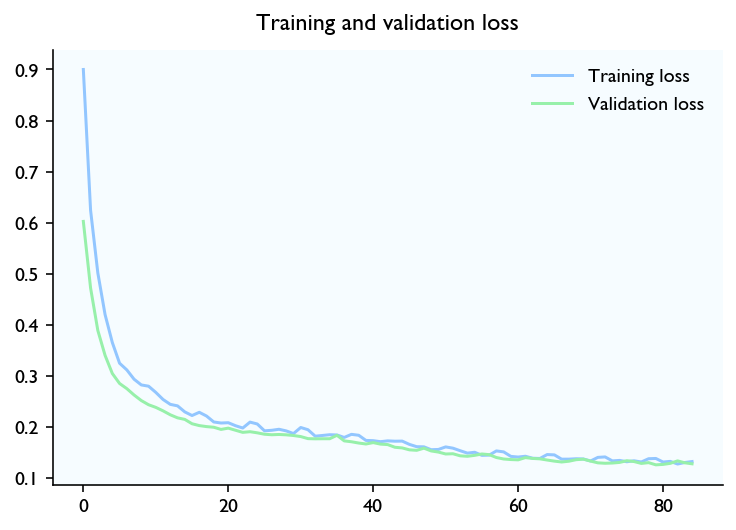

In [29]:
plot_train_history(history, 'Training and validation loss')

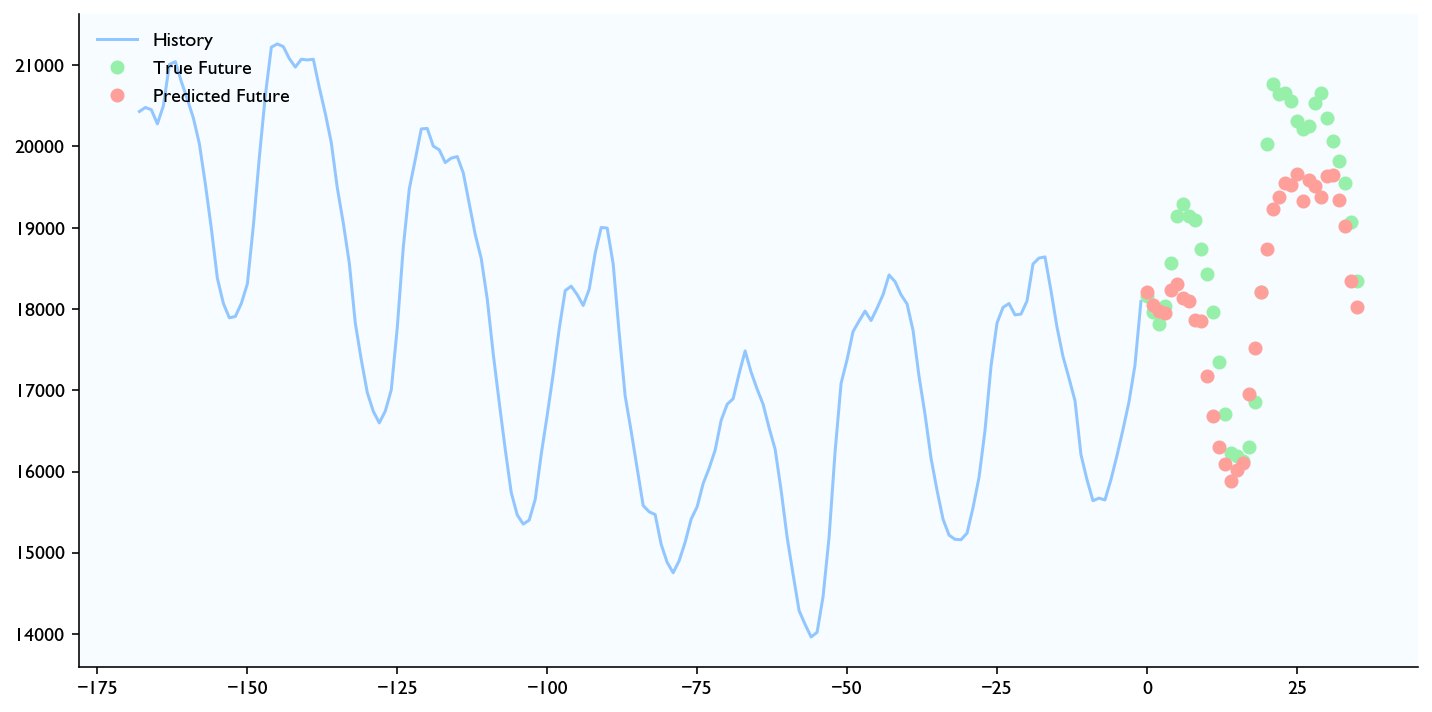

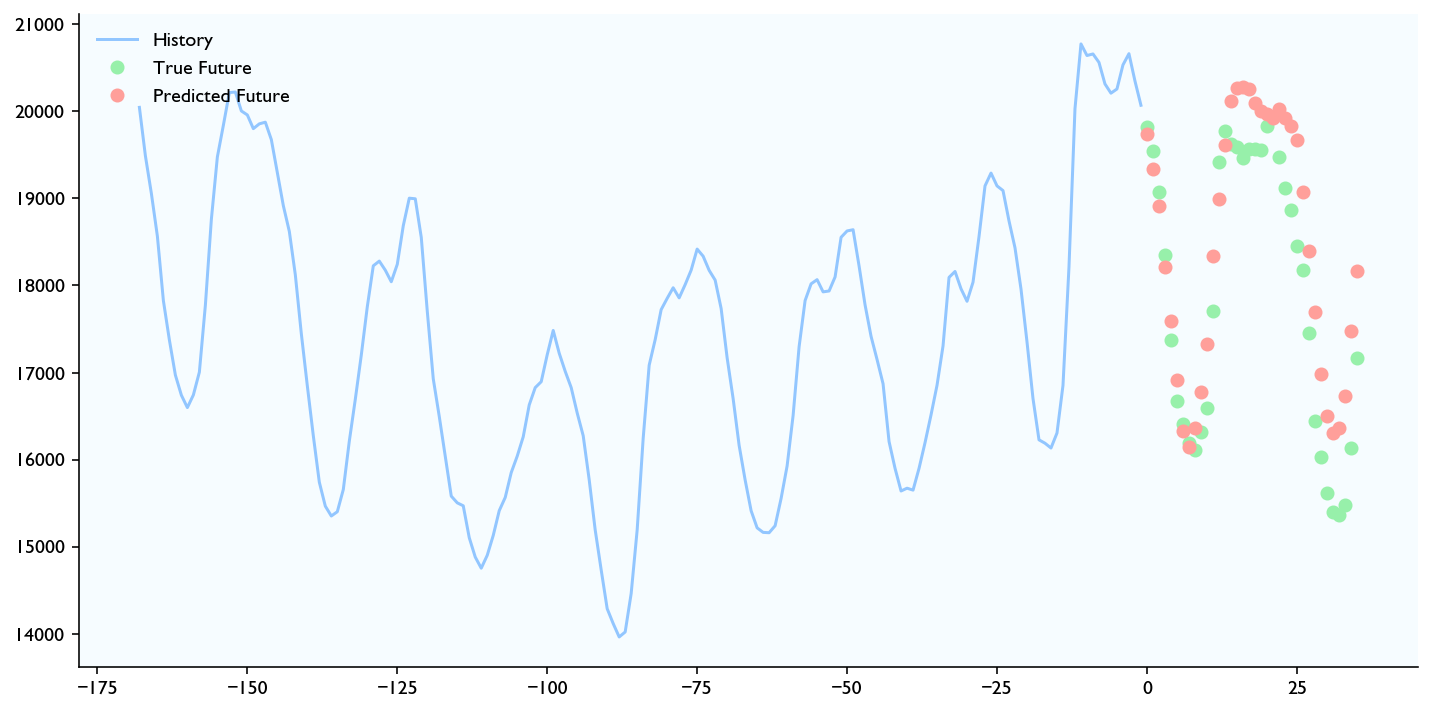

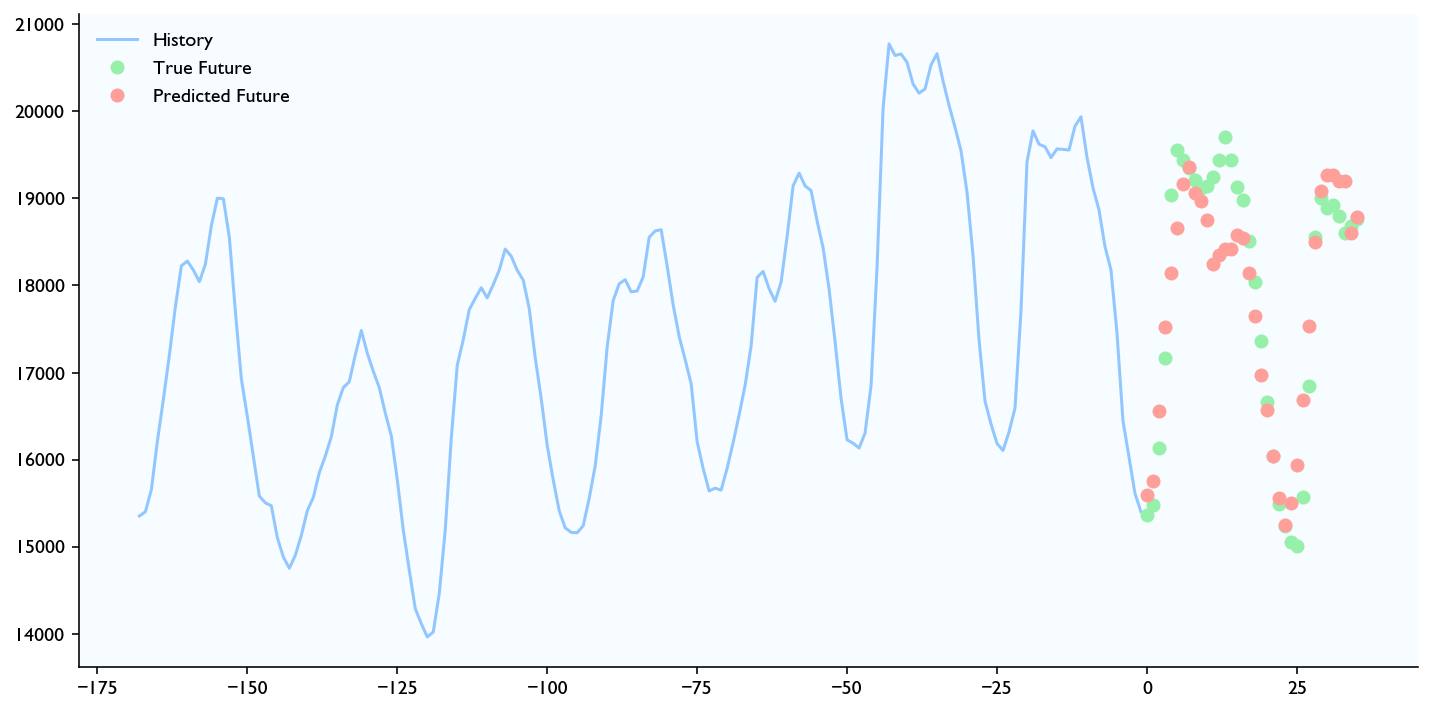

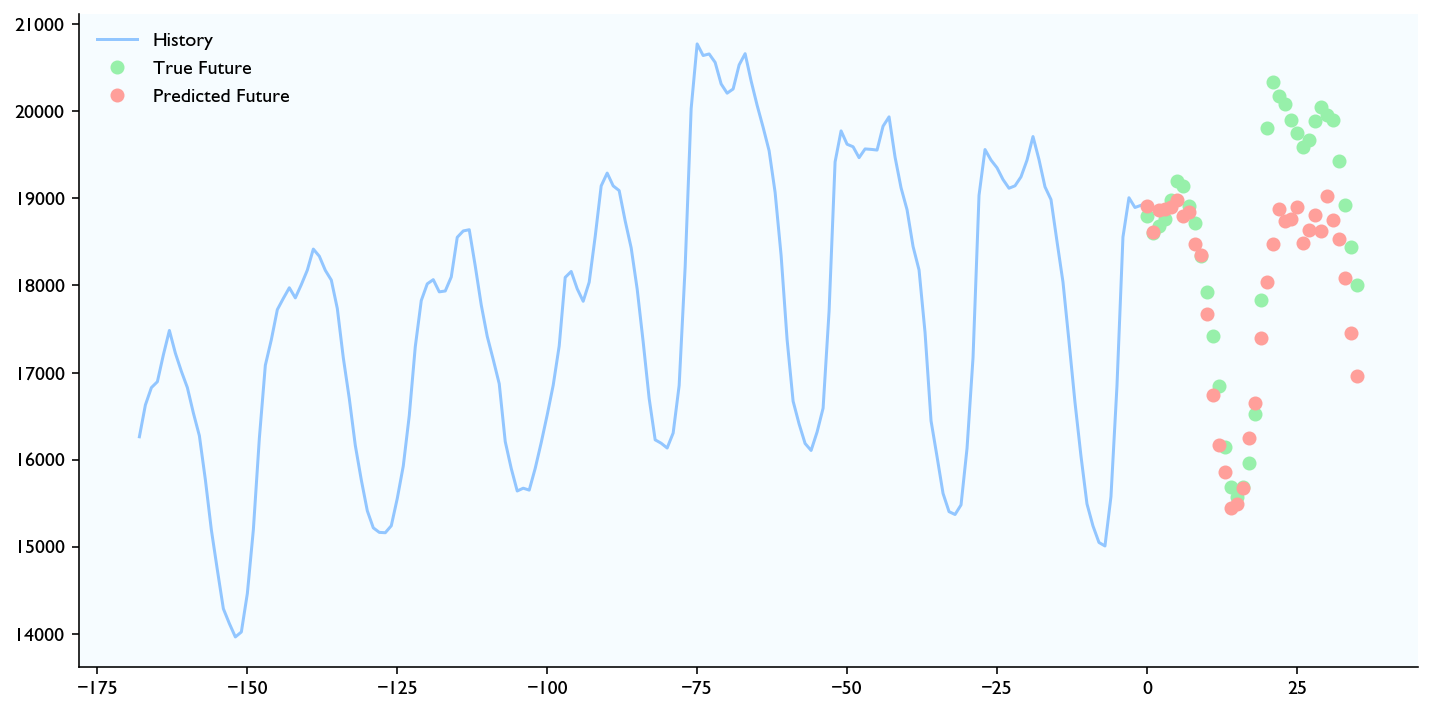

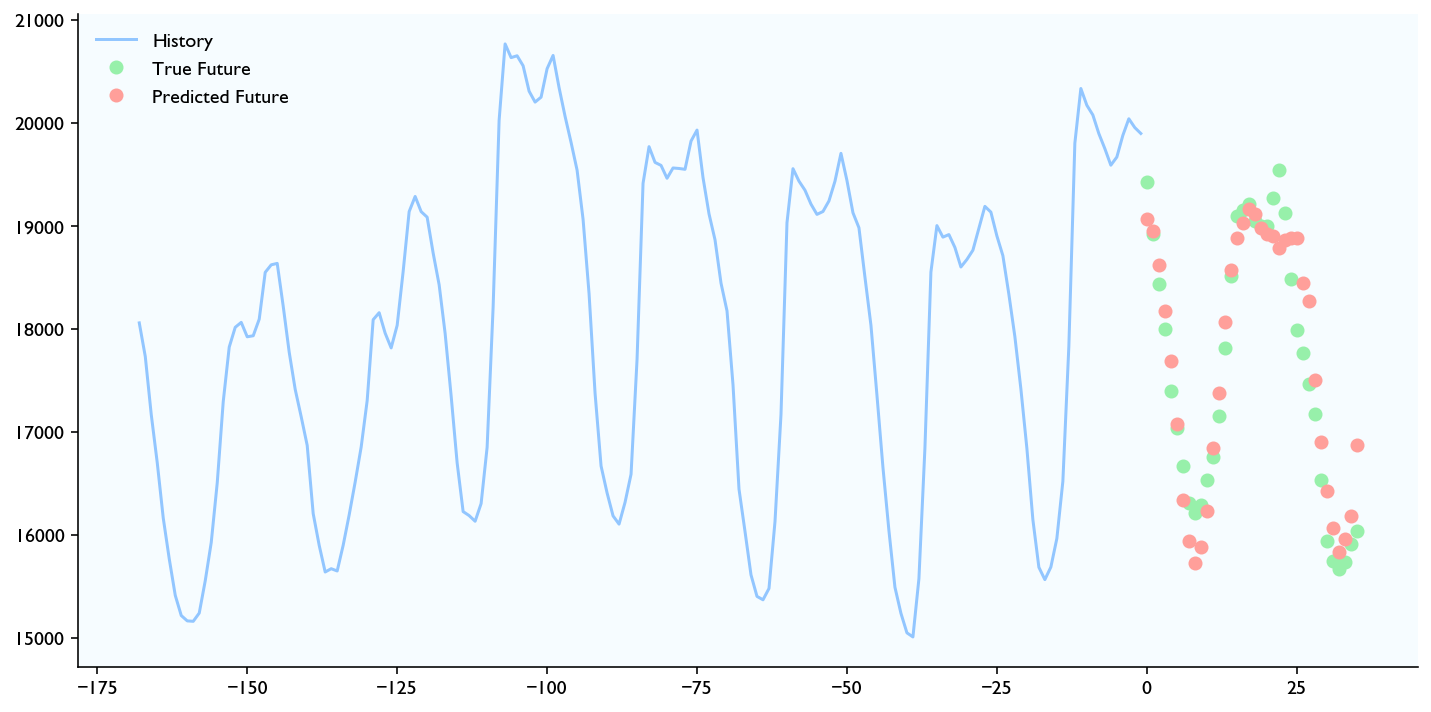

In [30]:
for x, y in val_data.take(5):
    step_plot(x[0], y[0], model.predict(x)[0])

In [31]:
mea_normalized = history.history['val_loss'][-1] # 0.1586
mea_denorm = denormalize(mea_normalized) - load_mean
print("MAE last epoch: %.2f MW" % (mea_denorm))

MAE last epoch: 417.05 MW
